In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.io import wavfile
import glob

In [46]:
def load_data(f1):
  w_size=25
  shift=10
  freq=16
  data = np.empty((0,w_size*freq))
  for i in range(len(f1)):
    sample,read_music=wavfile.read(f1[i])
    new_data=[]
    sample_ws=w_size*freq
    sample_shift=shift*freq
    index=0
    while (index + sample_ws - 1) <= read_music.shape[0]:
      t = []
      s=index
      f=index+sample_ws
      for j in range(s,f):
        t.append(read_music[j])
      new_data.append(t)
      index = index + sample_shift
    data=np.concatenate((data,np.array(new_data)),axis=0)
  return data
    
    



In [47]:
f1 = glob.glob("/content/drive/My Drive/speech_music_classification/train/music/*.wav")
f2=glob.glob("/content/drive/My Drive/speech_music_classification/train/speech/*.wav")
music_data=load_data(f1)
speech_data=load_data(f2)

In [48]:
speech_data.shape

(119920, 400)

In [51]:
import scipy
from scipy.fft import fft
#fft on music data
music_fft = scipy.fft.fft(music_data, n=64, axis=- 1)
music_fft=np.delete(music_fft,np.s_[32:],axis=1)
music=np.log(np.absolute(music_fft))
music.shape

(119920, 32)

In [52]:
#fft on speech data
speech_fft = scipy.fft.fft(speech_data, n=64, axis=- 1)
speech_fft=np.delete(speech_fft,np.s_[32:],axis=1)
speech_fft = np.where(speech_fft > 0.0000000001, speech_fft, 10)
speech=np.log(np.absolute(speech_fft))
speech.shape

(119920, 32)

# **Initialialising EM using K means**

In [53]:
from sklearn.cluster import KMeans
import numpy as np

# Initilization EM for music data
km = KMeans(
    n_clusters=2, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(music)

In [54]:

c0=[]
c1=[]
for i in range(len(y_km)):
  if(y_km[i]==0):
    c0.append(music[i])
  else:
    c1.append(music[i])


In [55]:
len(c1)

47205

In [56]:
import numpy as np
#initial alphas (music)
alpha1=len(c0)/1000
alpha2=len(c1)/1000

#initial means (music)
mean1=np.mean(np.array(c0),axis=0)
mean2=np.mean(np.array(c1),axis=0)

#initial varience (music)
var1=np.cov(np.array(c0).T)
var2=np.cov(np.array(c1).T)

In [57]:
from scipy.stats import multivariate_normal

In [58]:
#initializing EM for speech data
km = KMeans(
    n_clusters=2, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km_speech = km.fit_predict(speech)

alpha1_speech=0
alpha2_speech=1
c0_s=[]
c1_s=[]
for i in range(len(y_km)):
  if(y_km_speech[i]==0):
    c0_s.append(music[i])
  else:
    c1_s.append(music[i])

#initial alphas (speech)
alpha1_s=len(c0)/1000
alpha2_s=len(c1)/1000

#initial means (speech)
mean1_s=np.mean(np.array(c0_s),axis=0)
mean2_s=np.mean(np.array(c1_s),axis=0)

#initial varience (speech) diagonal covarience
var1_s=np.diag(np.diag(np.cov(np.array(c0_s).T)))
var2_s=np.diag(np.diag(np.cov(np.array(c1_s).T)))


# **function for log_likelihood**

In [59]:
def computeLikeli(likl1,likl2):
  m=np.add(likl1,likl2)
  m=np.where(m>0,m,1)
  log_likl=np.log10(m)
  T_likl=np.sum(log_likl)
  return T_likl
  

# **function EM iteration**

In [74]:
def ComputeEM(alpha1,alpha2,mean1,mean2,var1,var2,new,N,l):

  #E step
  distribution1 = multivariate_normal(mean=mean1, cov=var1)
  likl1 = distribution1.pdf(new)*alpha1
  distribution2 = multivariate_normal(mean=mean2, cov=var2)
  likl2 = distribution2.pdf(new)*alpha2
  post1=np.divide(likl1,np.add(likl1,likl2))
  post2=np.divide(likl2,np.add(likl1,likl2))
  l.append(computeLikeli(likl1,likl2))
  print("log liklehood",computeLikeli(likl1,likl2))


  #calculating new alpha
  new_alpha1=np.mean(post1)
  new_alpha2=np.mean(post2)
  c0=[]
  c1=[]
  
  for i in range(len(new)):
    c0.append(new[i]*post1[i])
    c1.append(new[i]*post2[i])
  
  #calculating new mean
  new_mean1=np.sum(np.array(c0),axis=0)/np.sum(post1)
  new_mean2=np.sum(np.array(c1),axis=0)/np.sum(post2)


  #calculating new diagonal varience
  xx=[]
  for i in range(len(new)):
    xx.append(new[i]- new_mean1)
  xx=np.array(xx)
  yy=[]
  for i in range(len(new)):
    yy.append(new[i]- new_mean2)
  yy=np.array(yy)

  var_new1 = np.zeros((new.shape[1],new.shape[1]))
  for i in range(len(xx)):
    temp = np.matrix(xx[i])
    a = np.matmul(temp.T,temp)
    a = a*post1[i]
    var_new1 = np.add(var_new1,a)
  var_new1=var_new1 / np.sum(post1)

  var_new2 = np.zeros((new.shape[1],new.shape[1]))
  for i in range(len(yy)):
    temp = np.matrix(yy[i])
    a = np.matmul(temp.T,temp)
    a = a*post2[i]
    var_new2= np.add(var_new2,a)
  

  var_new2=var_new2 / np.sum(post2)

  if N-1>0:
    return ComputeEM(new_alpha1,new_alpha2,new_mean1,new_mean2,var_new1,var_new2,new,N-1,l)
  else :
    alpha=[new_alpha1,new_alpha2]
    mean=[new_mean1,new_mean2]
    cov=[var_new1,var_new2]
    return l,np.array(alpha),np.array(mean),np.array(cov)
  


  


  


# **EM for music**

In [76]:
l_m,alpha_m,mean_m,cov_m=ComputeEM(alpha1,alpha2,mean1,mean2,var1,var2,music,10,[]
                    )


log liklehood -1476138.7128551346
log liklehood -1721880.1104225859
log liklehood -1716507.1238189363
log liklehood -1697218.8754378934
log liklehood -1652902.441805015
log liklehood -1614159.8426490172
log liklehood -1590939.77503817
log liklehood -1576326.4960212265
log liklehood -1567268.8203086576
log liklehood -1561857.5834366833


# **EM for speech**

In [78]:
l_s,alpha_s,mean_s,cov_s=ComputeEM(alpha1_s,alpha2_s,mean1_s,mean2_s,var1_s,var2_s,speech,10,[])

log liklehood -12554624.783392861
log liklehood -3717381.0599998
log liklehood -3535721.591514093
log liklehood -3426817.4999485593
log liklehood -3402284.3627906675
log liklehood -3389330.141889343
log liklehood -3380892.6513281693
log liklehood -3374247.4349500886
log liklehood -3368279.166611237
log liklehood -3362010.4205860016


In [79]:
del l_m[0]

# **plotting log likelihood for music data**

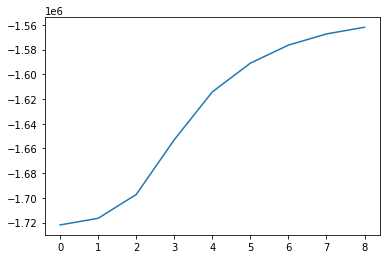

In [80]:
import matplotlib.pyplot as plt
plt.plot(l_m)

# **plotting log_likelihood for speech data**

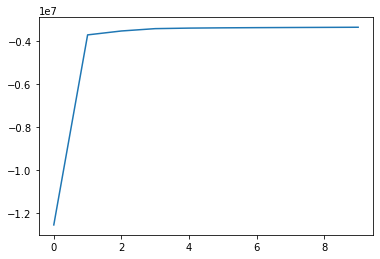

In [81]:
import matplotlib.pyplot as plt
plt.plot(l_s)

# **testing data**

In [82]:
f=glob.glob("/content/drive/My Drive/speech_music_classification/test/*.wav")
test_data=load_data(f)
test_data=load_data(f)
test_fft = scipy.fft.fft(test_data, n=64, axis=- 1)
test_fft=np.delete(test_fft,np.s_[32:],axis=1)
test_fft = np.where(test_fft > 0.0000000001, test_fft, 10)
test=np.log(np.absolute(test_fft))


In [83]:
labels=[]
for name in f:
  if "speech_music_classification/test/music" in name:

    labels.append(0)
  else:
    labels.append(1)
print(labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [86]:
prob_m=np.zeros(test.shape[0])
for i in range(2):
  distribution = multivariate_normal(mean=mean_m[i], cov=cov_m[i])
  prob_m = np.add(prob_m,distribution.pdf(test)*alpha_m[i])
print(prob_m.shape)



(143904,)


In [87]:
prob_s=np.zeros(test.shape[0])
for i in range(2):
  distribution = multivariate_normal(mean=mean_s[i], cov=cov_s[i])
  prob_s= np.add(prob_s,distribution.pdf(test)*alpha_s[i])
print(prob_s.shape)

(143904,)


In [110]:
pred_labels=[]
for i in range(len(labels)):
  sum1=0
  sum2=0
  for j in range(2998*i,2998*(i+1)):
    sum1=sum1+prob_m[j]
    sum2=sum2+prob_s[j]
  if(sum1<=sum2):
    pred_labels.append(0)
  else:
    pred_labels.append(1)
print(pred_labels)

[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0]


In [89]:
# pred_labels=[]
# for i in range(len(labels)):
#   sum=0
#   for j in range(2998*i,2998*(i+1)):
#     sum=sum+y[j]
#   if(sum<(2998/2)):
#     pred_labels.append(0)
#   else:
#     pred_labels.append(1)

In [108]:
from sklearn.metrics import accuracy_score
print("accuracy:",accuracy_score(labels, pred_labels))

accuracy: 0.6041666666666666
